## Resources
https://github.com/aws/amazon-sagemaker-examples/blob/main/introduction_to_applying_machine_learning/ntm_20newsgroups_topic_modeling/ntm_20newsgroups_topic_model.ipynb

## Data Preparation

In [1]:
import pandas as pd

data = pd.read_csv("comments_final.csv")['Review']

## From Plain Text to Bag of Words (BOW)
Input documents in the algorithm need to be vectors of integers representing word counts (BOW)

Process:
- tokenize documents (identify words and assign integer id)
- count occurence of each token and form BOW vectors
- use of stemming and lemmatization
    - improves training and computing time(reduces vocab size)
    - improves quality of learned topic-word probability matrices and inferred topic mixtures

In [2]:
import nltk

nltk.download("punkt")
nltk.download("wordnet")
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# --token counting--

# rule: only consider words longer than 2 characters,
# start with a letter and match the token_pattern
token_pattern = re.compile(r"(?u)\b\w\w+\b")

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()

    def __call__(self, doc):
        return [
            self.wnl.lemmatize(t)
            for t in word_tokenize(doc)
            if len(t) >= 2 and re.match("[a-z].*", t) and re.match(token_pattern, t)
        ]

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [3]:
import time
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# token counting performed while limiting vocab size to vocab_size
vocab_size = 1103  # num extracted from vocab size derived
print("Tokenizing and counting, this may take a few minutes...")
start_time = time.time()

# performs token counting
vectorizer = CountVectorizer(
    input="content",
    analyzer="word",
    stop_words="english",
    tokenizer=LemmaTokenizer(),
    max_features=vocab_size,
    max_df=0.95,  # max doc frequency of 95%
    min_df=2,     # min doc frequency of 2 docs
)

vectors = vectorizer.fit_transform(data)
vocab_list = vectorizer.get_feature_names()
print("vocab size:", len(vocab_list))

# random shuffle
idx = np.arange(vectors.shape[0])
np.random.shuffle(idx)
vectors = vectors[idx]

print("Done. Time elapsed: {:.2f}s".format(time.time() - start_time))

Tokenizing and counting, this may take a few minutes...


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


vocab size: 1103
Done. Time elapsed: 2.41s


In [4]:
#removing documents shorter than 10 words
threshold = 10

vectors = vectors[
    np.array(vectors.sum(axis=1) > threshold).reshape(
        -1,
    )
]

print("removed short docs (<{} words)".format(threshold))
print(vectors.shape)

removed short docs (<10 words)
(352, 1103)


In [5]:
# returns sparse matrices with integer elements
print(type(vectors), vectors.dtype)
print(vectors[0])

<class 'scipy.sparse.csr.csr_matrix'> int64
  (0, 62)	2
  (0, 345)	1
  (0, 729)	1
  (0, 978)	2
  (0, 194)	1
  (0, 497)	1
  (0, 833)	2
  (0, 581)	1
  (0, 578)	1
  (0, 278)	1
  (0, 877)	1
  (0, 769)	1


In [6]:
import scipy.sparse as sparse

#all parameters in NTM are np.float32
#input data converted to np.float32
vectors = sparse.csr_matrix(vectors, dtype=np.float32)
print(type(vectors), vectors.dtype)

<class 'scipy.sparse.csr.csr_matrix'> float32


In modeling training, a training set, validation set, and test set are needed

Training: set of data model is actually being trained on
- periodically calculate scores on the validation set to validate performance of model on unseen data
- stop training at optimal point to avoid over-training

Validation set is needed in order to prevent over-training of NTM model

In [7]:
#80% of data used as training and rest for validation and test
#validation used for training and test used for demonstrating model inference
n_train = int(0.8 * vectors.shape[0])

# split train and test
train_vectors = vectors[:n_train, :]
test_vectors = vectors[n_train:, :]

# further split test set into validation set (val_vectors) and test  set (test_vectors)
n_test = test_vectors.shape[0]
val_vectors = test_vectors[: n_test // 2, :]
test_vectors = test_vectors[n_test // 2 :, :]

In [8]:
print(train_vectors.shape, test_vectors.shape, val_vectors.shape)

(281, 1103) (36, 1103) (35, 1103)


## Store Data on S3

In [9]:
import os
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()

sess = sagemaker.Session()
bucket = 'sagemaker-studio-share'

In [10]:
prefix = "ntm/commentTires"

train_prefix = os.path.join(prefix, "train")
val_prefix = os.path.join(prefix, "val")
output_prefix = os.path.join(prefix, "output")

s3_train_data = os.path.join("s3://", bucket, train_prefix)
s3_val_data = os.path.join("s3://", bucket, val_prefix)
output_path = os.path.join("s3://", bucket, output_prefix)
print("Training set location", s3_train_data)
print("Validation set location", s3_val_data)
print("Trained model will be saved at", output_path)

Training set location s3://sagemaker-studio-share/ntm/commentTires/train
Validation set location s3://sagemaker-studio-share/ntm/commentTires/val
Trained model will be saved at s3://sagemaker-studio-share/ntm/commentTires/output


In [11]:
# RecordIO Protobuf format: converted into binary representation of 
# 4-byte floats and loads into protobuf values field
def split_convert_upload(sparray, bucket, prefix, fname_template="data_part{}.pbr", n_parts=2):
    import io
    import boto3
    import sagemaker.amazon.common as smac

    chunk_size = sparray.shape[0] // n_parts
    for i in range(n_parts):

        # Calculate start and end indices
        start = i * chunk_size
        end = (i + 1) * chunk_size
        if i + 1 == n_parts:
            end = sparray.shape[0]

        # Convert to record protobuf
        buf = io.BytesIO()
        smac.write_spmatrix_to_sparse_tensor(array=sparray[start:end], file=buf, labels=None)
        buf.seek(0)

        # Upload to s3 location specified by bucket and prefix
        fname = os.path.join(prefix, fname_template.format(i))
        boto3.resource("s3").Bucket(bucket).Object(fname).upload_fileobj(buf)
        print("Uploaded data to s3://{}".format(os.path.join(bucket, fname)))

In [12]:
split_convert_upload(
    train_vectors, bucket=bucket, prefix=train_prefix, fname_template="train_part{}.pbr", n_parts=8
)
split_convert_upload(
    val_vectors, bucket=bucket, prefix=val_prefix, fname_template="val_part{}.pbr", n_parts=1
)

Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part0.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part1.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part2.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part3.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part4.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part5.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part6.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/train/train_part7.pbr
Uploaded data to s3://sagemaker-studio-share/ntm/commentTires/val/val_part0.pbr


## Model Training
Configuring a sagemaker training job to use the prepared NTM algorithm

In [13]:
import boto3
from sagemaker.image_uris import retrieve

container = retrieve("ntm", boto3.Session().region_name)

In [14]:
import sagemaker

#automatically chooses an alogirithm container based on current region
sess = sagemaker.Session()
ntm = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=2,
    instance_type="ml.c4.xlarge",
    output_path=output_path,
    sagemaker_session=sess,
)

## Hyperparameters

In [37]:
num_topics = 10
ntm.set_hyperparameters(
    num_topics=num_topics,
    feature_dim=vocab_size,
    mini_batch_size=128,
    epochs=100,
    num_patience_epochs=3,
    tolerance=0.001,
)

In [38]:
# speficifation of how training data and valiation data will be distributed
# distribution values:
    #FullyReplicated: all data files copied to all workers
    #ShardedByS3Key: data files sharded to different workers
from sagemaker.inputs import TrainingInput

s3_train = TrainingInput(s3_train_data, distribution="ShardedByS3Key")

In [39]:
# training process
ntm.fit({"train": s3_train, "validation": s3_val_data})

2022-03-30 07:10:57 Starting - Starting the training job...
2022-03-30 07:11:23 Starting - Preparing the instances for trainingProfilerReport-1648624257: InProgress
.........
2022-03-30 07:12:50 Downloading - Downloading input data...
2022-03-30 07:13:10 Training - Downloading the training image...
2022-03-30 07:13:50 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
[03/30/2022 07:13:56 INFO 139801529890624 integration.py:636] worker started
[03/30/2022 07:13:56 INFO 139801529890624] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/default-input.json: {'encoder_la

In [40]:
print("Training job name: {}".format(ntm.latest_training_job.job_name))

Training job name: ntm-2022-03-30-07-10-57-712


## Model Hosting and Inference
Using the model to perform inference on data

In [41]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

ntm_predictor = ntm.deploy(
    initial_instance_count=1,
    instance_type="ml.m4.xlarge",
    serializer=CSVSerializer(),
    deserializer=JSONDeserializer(),
)

-------!

In [42]:
print("Endpoint name: {}".format(ntm_predictor.endpoint_name))

Endpoint name: ntm-2022-03-30-07-14-43-302


In [48]:
test_data = np.array(test_vectors.todense())
results = ntm_predictor.predict(test_data[:10])
print(results)

{'predictions': [{'topic_weights': [0.1058430746, 0.1014523357, 0.0904826298, 0.095162861, 0.0985653922, 0.1119816527, 0.0958334953, 0.0774569064, 0.0908701196, 0.1323515326]}, {'topic_weights': [0.1046361849, 0.1003728062, 0.0933218226, 0.0963502377, 0.0981435105, 0.1086161882, 0.0976566747, 0.0840893239, 0.0935864151, 0.1232268512]}, {'topic_weights': [0.1054099873, 0.1011907309, 0.0909428373, 0.0953805298, 0.098705247, 0.1111631766, 0.0962012932, 0.0789502114, 0.0916484147, 0.1304075271]}, {'topic_weights': [0.1032081693, 0.0998822525, 0.0960021019, 0.0973289162, 0.0975634903, 0.1057101116, 0.0993679985, 0.0902152658, 0.0957135782, 0.1150081009]}, {'topic_weights': [0.1039087698, 0.0999538377, 0.0947371349, 0.0969901085, 0.0976432413, 0.1071557477, 0.0987916589, 0.0878592134, 0.0948566198, 0.1181037128]}, {'topic_weights': [0.1060861126, 0.1013164222, 0.0907030106, 0.0950350687, 0.0984542891, 0.1116873473, 0.0959659964, 0.0782032907, 0.0909786075, 0.131569922]}, {'topic_weights': [0

In [49]:
predictions = np.array([prediction["topic_weights"] for prediction in results["predictions"]])
print(predictions)

[[0.10584307 0.10145234 0.09048263 0.09516286 0.09856539 0.11198165
  0.0958335  0.07745691 0.09087012 0.13235153]
 [0.10463618 0.10037281 0.09332182 0.09635024 0.09814351 0.10861619
  0.09765667 0.08408932 0.09358642 0.12322685]
 [0.10540999 0.10119073 0.09094284 0.09538053 0.09870525 0.11116318
  0.09620129 0.07895021 0.09164841 0.13040753]
 [0.10320817 0.09988225 0.0960021  0.09732892 0.09756349 0.10571011
  0.099368   0.09021527 0.09571358 0.1150081 ]
 [0.10390877 0.09995384 0.09473713 0.09699011 0.09764324 0.10715575
  0.09879166 0.08785921 0.09485662 0.11810371]
 [0.10608611 0.10131642 0.09070301 0.09503507 0.09845429 0.11168735
  0.095966   0.07820329 0.09097861 0.13156992]
 [0.10300536 0.09979062 0.09618095 0.09746064 0.09763331 0.10531101
  0.09942448 0.09100593 0.09626585 0.11392181]
 [0.10505623 0.10068171 0.09285746 0.09607846 0.09795269 0.10937315
  0.09757613 0.08324666 0.09282082 0.12435672]
 [0.10423121 0.10022277 0.09412465 0.09675318 0.0977496  0.10792083
  0.09837157

## Inference with RecordIO Protobuf

In [50]:
def recordio_protobuf_serializer(spmatrix):
    import io
    import sagemaker.amazon.common as smac

    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(array=spmatrix, file=buf, labels=None)
    buf.seek(0)
    return buf

Text(0.5, 0, 'Topic ID')

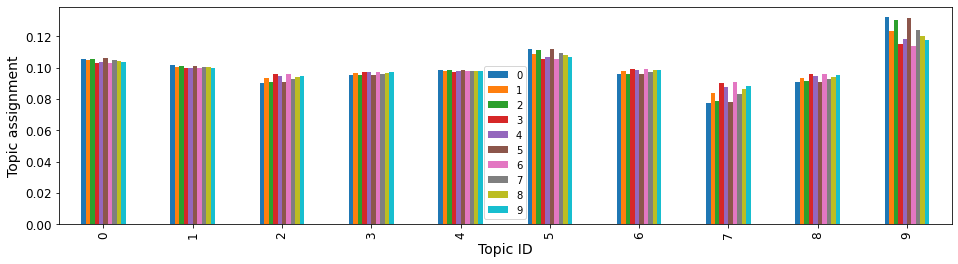

In [51]:
import matplotlib.pyplot as plt

%matplotlib inline

fs = 12
df = pd.DataFrame(predictions.T)
df.plot(kind="bar", figsize=(16, 4), fontsize=fs)
plt.ylabel("Topic assignment", fontsize=fs + 2)
plt.xlabel("Topic ID", fontsize=fs + 2)

In [36]:
sagemaker.Session().delete_endpoint(ntm_predictor.endpoint_name)


In [47]:
df

,0,1,2,3,4
0,0.105843,0.104636,0.105410,0.103208,0.103909
1,0.101452,0.100373,0.101191,0.099882,0.099954
2,0.090483,0.093322,0.090943,0.096002,0.094737
3,0.095163,0.096350,0.095381,0.097329,0.096990
4,0.098565,0.098144,0.098705,0.097563,0.097643
5,0.111982,0.108616,0.111163,0.105710,0.107156
6,0.095833,0.097657,0.096201,0.099368,0.098792
7,0.077457,0.084089,0.078950,0.090215,0.087859
8,0.090870,0.093586,0.091648,0.095714,0.094857
9,0.132352,0.123227,0.130408,0.115008,0.118104
